### TDSE: Time Dependent Schrodinger Equation 1D
$$
i\hbar \frac{d \psi (x,t)}{dt} = \frac{-\hbar^2}{2m} \frac{\partial^2 \psi (x,t)}{\partial x} + V(x,t) \psi (x,t)
\\
i\frac{\partial \psi}{\partial t'} = -\frac{1}{2}\frac{\partial^2 \psi}{\partial x'^2 } + V'(x)\psi
$$
#### Finite diferenece
$$
i\frac{\psi^{m+1}_{j} + \psi^{m}_{j}}{\Delta t} = -\frac{1}{2} \frac{\psi^{m}_{j+1} -2\psi^{m}_{j} + \psi^{m}_{j-1}}{\Delta x ^2} + V(x)\psi^{m}_{j} 
$$
$\psi$ of next time step at the position $j$
$$
\psi^{m+1}_{j} = \psi^{m}_{j} + \frac{i\Delta t}{2\Delta x^2}[\psi^{m}_{j+1} -2\psi^{m}_{j} + \psi^{m}_{j-1}] -i\Delta t V(x) \psi^{m}_{j} 
$$

## Gauusian wave packets equation
$\hbar$ and $m = 1$
$$
\psi_x(x,t = 0) = \left(\frac{1}{2\pi\sigma^2_x}\right)^\frac{1}{4} exp(ip_0x -\frac{(x-x_0)^2}{4\sigma^2_x})
$$

In [487]:
# requirements and imports

import numpy as np
from matplotlib import pyplot as plt

In [729]:
# system parameter
N = 100
x,dx = np.linspace(-5,5, N , retstep= True)
# x.astype(complex)
T = 0.0001
Nt = 10000
dt = 1e-4


# gaussain wave package generator
def gen_gaussian(x,x0,sigma, p0):
    A = (1 / (2 * np.pi * sigma**2))**(0.25)
    B = np.exp((-(x-x0)**2) / ((4 * sigma)**2))
    C = np.exp(1j*p0*x)
    return A * B * C

# sine wave generator
def gen_sine(x):
    A = 1
    return A * np.sin(x)


# potential

def V_free_particle(x):
    return x * 0 

def V_well(x):
    mu ,sigma = 1/2 , 1/20
    A = -1e4
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def V_harmonic(x):
    k = 10
    x0 = 1
    return 1/2 * k * (x-x0)**2  



# probability density
def density(psi):
    return psi * np.conj(psi)


def get_psi(psi,V):
    psi_next = np.zeros(N,dtype='cfloat')
    for i in range(1,len(psi)-1):
        # print(f'{psi[i]},{1j/2 * dt/dx**2 * (psi[i+1] - 2*psi[i] + psi[i-1])},{1j*dt*V(psi[i])*psi[i]}')
        psi_next[i] = psi[i] + (1j/2 * dt/dx**2 * (psi[i+1] - 2*psi[i] + psi[i-1])) - (1j*dt*V[i]*psi[i]) 
    return psi_next



def simulation(psi,V):
    t = 0
    psi_tot = psi.copy()
    while t < Nt:
        psi = get_psi(psi,V)
        psi_tot = np.vstack((psi_tot,psi))
        # t = t + dt
        t = t + 1 

    return psi_tot




In [739]:
# psi0 as gaussian
psi = gen_gaussian(x, x0 = 0.5 , sigma = 1/5 , p0 = 50)

# psi0
# psi = gen_sine(x)

V0 = V_free_particle(x)
psi_m00 = simulation(psi.astype(complex),V0)



C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


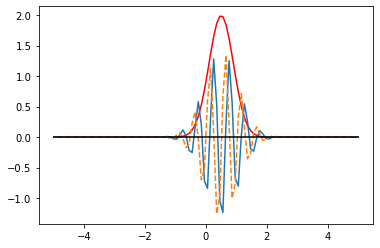

0.00099 0.014142135623730952


In [740]:
plt.plot(x,density(psi), color = 'r')
plt.plot(x,psi.real)
plt.plot(x,psi.imag,'--')
plt.plot(x,V0,color = 'Black')
# plt.ylim(-1,1)
# plt.plot(x,density(get_psi(psi)))
plt.show()
# plt.plot(V0)

print(dt/dx , 1/100 * np.sqrt(2))

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(10001, 100)

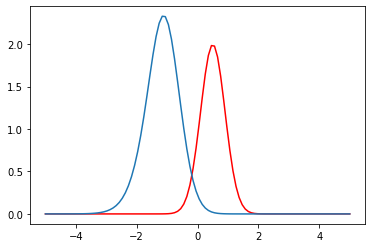

In [741]:
plt.plot(x,density(psi_m00[0]) , 'r')
plt.plot(x,density(psi_m00[-1]))
# plt.plot(x,psi_m00.real[-1])
# plt.plot(x,psi_m00[0])
# plt.plot(x,psi_m00[-1])

# t1  = 1j * (psi_m00[0] + psi_m00[1]) / dt 
# t2 =  -1/2 * ( psi_m00[1] - 2*psi_m00[0]) / dx**2

# t1-t2 < 1e-4

psi_m00.dtype
psi_m00.shape

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


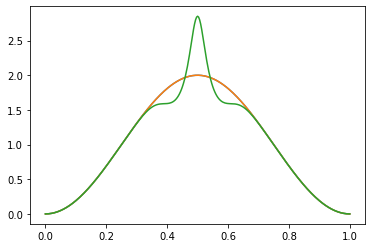

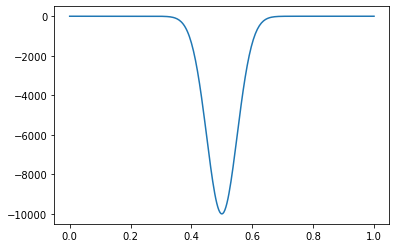

In [636]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit
from scipy.linalg import eigh_tridiagonal


Nx = 301
Nt = 5000
dx = 1/(Nx-1)
dt=1e-7
x = np.linspace(0, 1, Nx)

psi0 = np.sqrt(2)*np.sin(np.pi*x)
# psi0 = gen_gaussian(x,x0 = 0 ,sigma= 2,p0=2)
mu, sigma = 1/2, 1/20
V = -1e4*np.exp(-(x-mu)**2/(2*sigma**2))

psi = np.zeros([Nt,Nx],dtype= 'cfloat')
psi[0] = psi0


@numba.jit("c16[:,:](c16[:,:])", nopython=True, nogil=True)
def compute_psi(psi):
    for t in range(0, Nt-1):
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t][i] + 1j/2 * dt/dx**2 * (psi[t][i+1] - 2*psi[t][i] + psi[t][i-1]) - 1j*dt*V[i]*psi[t][i]
        
        normal = np.sum(np.absolute(psi[t+1])**2)*dx
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t+1][i]/normal
        
    return psi

psi_m1 = compute_psi(psi.astype(complex))
# plt.plot(x, np.abs(psi_m1[4000])**2) 
plt.plot(x, density(psi[0]))
plt.plot(x, density(psi_m1[0]))
plt.plot(x, density(psi_m1[4000]))
plt.show()
plt.plot(x, V)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:131

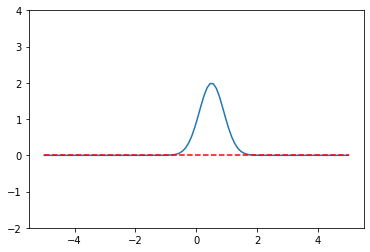

In [742]:
# animation
from matplotlib.animation import FuncAnimation
import os

# function update 1d wave over time

def update(frame):
    plt.clf()
    plt.plot(x, density(psi_m00[50*frame,:]))
    plt.plot(x,V0,'--', color = 'r')
    plt.ylim(-2,4)



fig,ax = plt.subplots()
line, = ax.plot(x,density(psi_m00[0]))
line, = ax.plot(x, V0 , '--' ,color = 'r')
plt.ylim(-2,4)


#number of frames 
nframes = len(psi_m00) // 50

ani = FuncAnimation(fig,update, frames = nframes, interval = 1)


# save animation
file_format = 'gif'
file_name = '1D TDSE v0.3.5'

directory = '/Users/Admin/Desktop/senior/animation'
output_file = os.path.join(directory, f'{file_name}.{file_format}')

ani.save(output_file, writer='pillow', fps=15)

plt.show()
